# **Cluster Dataset**

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append('../')

import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from src.config import DEVICE

from src.datasets.cluster_dataset import ClusterDataset, get_cluster_dataloader
from src.utils.block_dictionary import get_block_id_dictionary
from src.mca.cluster import Cluster
from src.mca.section import Section

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

DATA_PATH = '../data/'
CLUSTER_DATASET_PATH = DATA_PATH + 'cluster_dataset/'

In [9]:
block_id_dict = get_block_id_dictionary()
num_block_classes = len(block_id_dict)
cluster_dataloader = get_cluster_dataloader(CLUSTER_DATASET_PATH, num_block_classes=num_block_classes, num_workers = 0)

✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.


🔄 Loading clusters: 100%|██████████| 2/2 [00:00<00:00, 47.61it/s]


In [10]:
# # get class weights
# import torch
# from tqdm import tqdm

# class_weights = torch.zeros(num_block_classes + 1)

# for i, batch in tqdm(enumerate(cluster_dataloader)):
#     cluster_masked, cluster_gt = batch
#     class_weights += torch.sum(cluster_gt, dim=(2, 3, 4))[0]
    
#     if i == 100:
#         break

# class_weights = (class_weights + 1e-5) / (torch.sum(class_weights) + 1e-5)
# class_weights = 1e-5 / (class_weights + 1e-5)

# # save class weights
# np.save('../data/class_weights.npy', class_weights.numpy())

100it [00:52,  1.89it/s]


In [11]:
# read class weights
class_weights = np.load('../data/class_weights.npy')

In [13]:
from src.models.unet import UNet3D

num_epochs = 1
learning_rate = 0.001
model = UNet3D().to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights).float().to(DEVICE))
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
best_loss = np.inf
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    
    total = len(cluster_dataloader)
    bar = tqdm(total=total, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, batch in enumerate(cluster_dataloader):
        cluster_masked, cluster_gt = batch
        cluster_masked = cluster_masked.to(DEVICE)
        cluster_gt = cluster_gt.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(cluster_masked)
        
        # Compute the loss
        loss = criterion(outputs, cluster_gt)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if batch_idx % 10 == 9:  # Print every 100 mini-batches
            print('[Epoch %d, Batch %5d] Loss: %.8f' %
                  (epoch + 1, batch_idx + 1, running_loss / 100))

            if running_loss < best_loss:
                best_loss = running_loss
                torch.save(model.state_dict(), '../data/unet3d.pt')
                print('Saved model weights')

            running_loss = 0.0

        bar.update(1)

print('Finished Training')

Epoch 1/1:   0%|          | 9/19136 [00:07<4:30:27,  1.18it/s]

[Epoch 1, Batch    10] Loss: 0.00055573
Saved model weights


Epoch 1/1:   0%|          | 19/19136 [00:16<4:22:01,  1.22it/s]

[Epoch 1, Batch    20] Loss: 0.00048844
Saved model weights


Epoch 1/1:   0%|          | 30/19136 [00:25<4:17:16,  1.24it/s]

[Epoch 1, Batch    30] Loss: 0.00049368


Epoch 1/1:   0%|          | 39/19136 [00:32<4:20:03,  1.22it/s]

[Epoch 1, Batch    40] Loss: 0.00046310


Epoch 1/1:   0%|          | 40/19136 [00:33<4:38:07,  1.14it/s]

Saved model weights


Epoch 1/1:   0%|          | 49/19136 [00:41<4:22:04,  1.21it/s]

[Epoch 1, Batch    50] Loss: 0.00025324
Saved model weights


Epoch 1/1:   0%|          | 59/19136 [00:49<4:19:47,  1.22it/s]

[Epoch 1, Batch    60] Loss: 0.00021338
Saved model weights


Epoch 1/1:   0%|          | 70/19136 [00:58<4:17:27,  1.23it/s]

[Epoch 1, Batch    70] Loss: 0.00023190


Epoch 1/1:   0%|          | 80/19136 [01:06<4:17:27,  1.23it/s]

[Epoch 1, Batch    80] Loss: 0.00034382


Epoch 1/1:   0%|          | 90/19136 [01:15<4:20:25,  1.22it/s]

[Epoch 1, Batch    90] Loss: 0.00029128


Epoch 1/1:   1%|          | 100/19136 [01:23<4:17:34,  1.23it/s]

[Epoch 1, Batch   100] Loss: 0.00046901


Epoch 1/1:   1%|          | 105/19136 [01:27<4:22:20,  1.21it/s]

KeyboardInterrupt: 

In [21]:
model = UNet3D().to(DEVICE)
model.load_state_dict(torch.load('../data/unet3d.pt'))
model.eval()

UNet3D(
  (encoder_conv1): Conv3d(1006, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (encoder_conv2): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (encoder_conv3): Conv3d(512, 1024, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (encoder_maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder_conv1): ConvTranspose3d(1024, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (decoder_conv2): ConvTranspose3d(768, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
  (decoder_conv3): Conv3d(512, 1006, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (relu): ReLU(inplace=True)
)

In [22]:
for i, batch in enumerate(cluster_dataloader):
    cluster_masked, cluster_gt = batch
    cluster_masked = cluster_masked.to(DEVICE)
    cluster_pred = model(cluster_masked)

    cluster_pred = cluster_pred.detach().cpu().numpy()

    # one hot to idx
    cluster_pred = np.argmax(cluster_pred, axis=1)[0]

    # reshape back to original shape
    cluster_pred = cluster_pred.transpose((0, 2, 1)) \
        .reshape((3, 16, 3, 16, 3, 16)) \
        .transpose((0, 2, 4, 5, 3, 1))
    
    cluster = Cluster(cluster_pred)
    cluster.display()

    center_section = cluster.get_section(1, 1, 1)
    center_section.display()

    if i == 10:
        break

ValueError: cannot reshape array of size 4096 into shape (3,16,3,16,3,16)

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


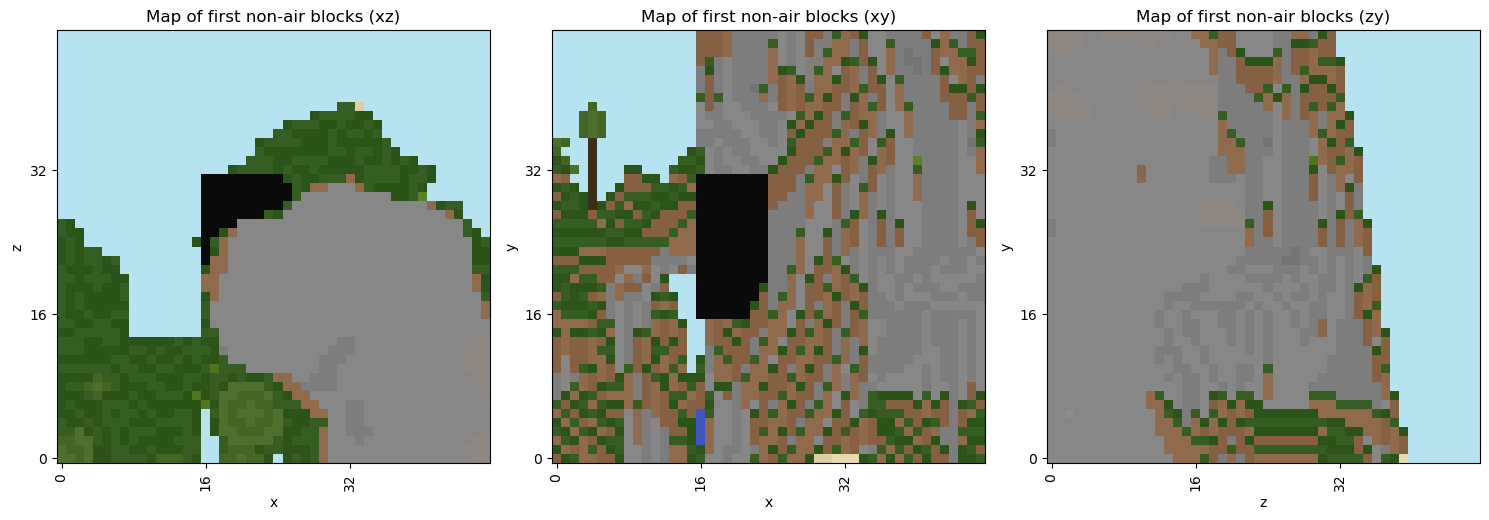

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


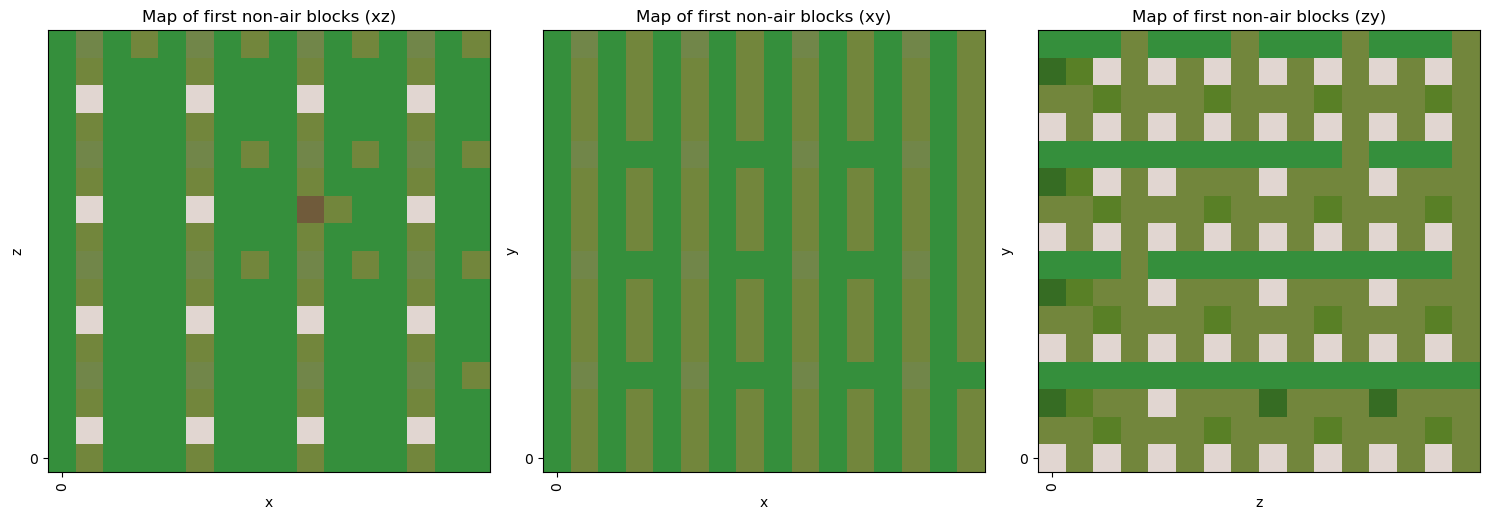

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


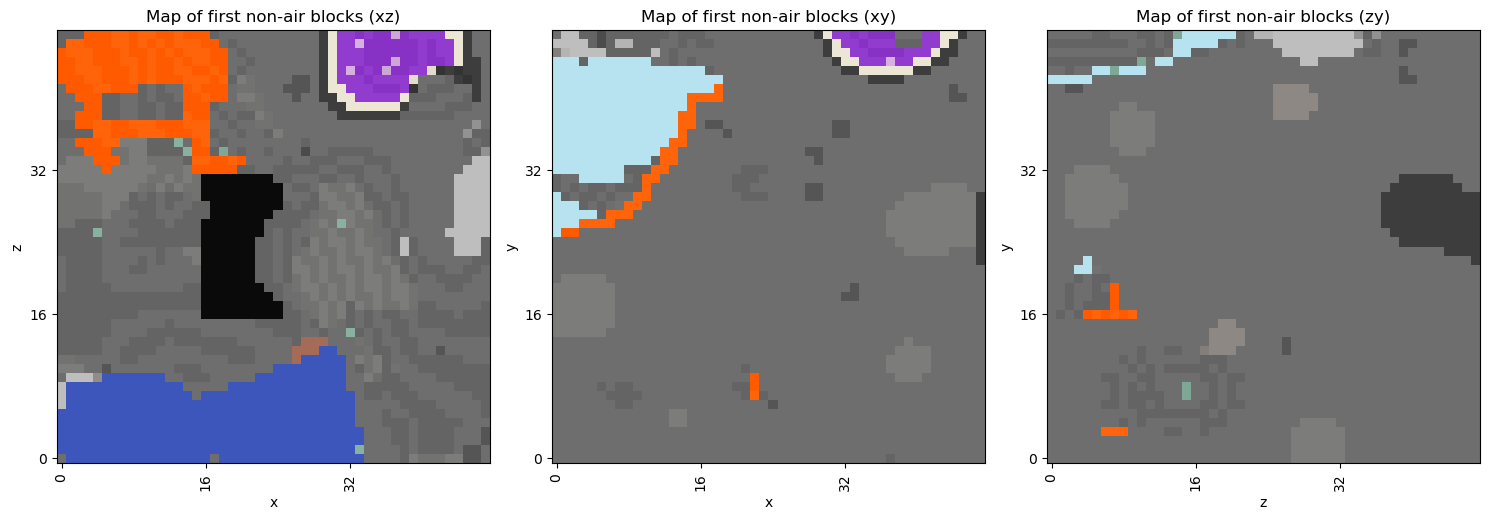

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


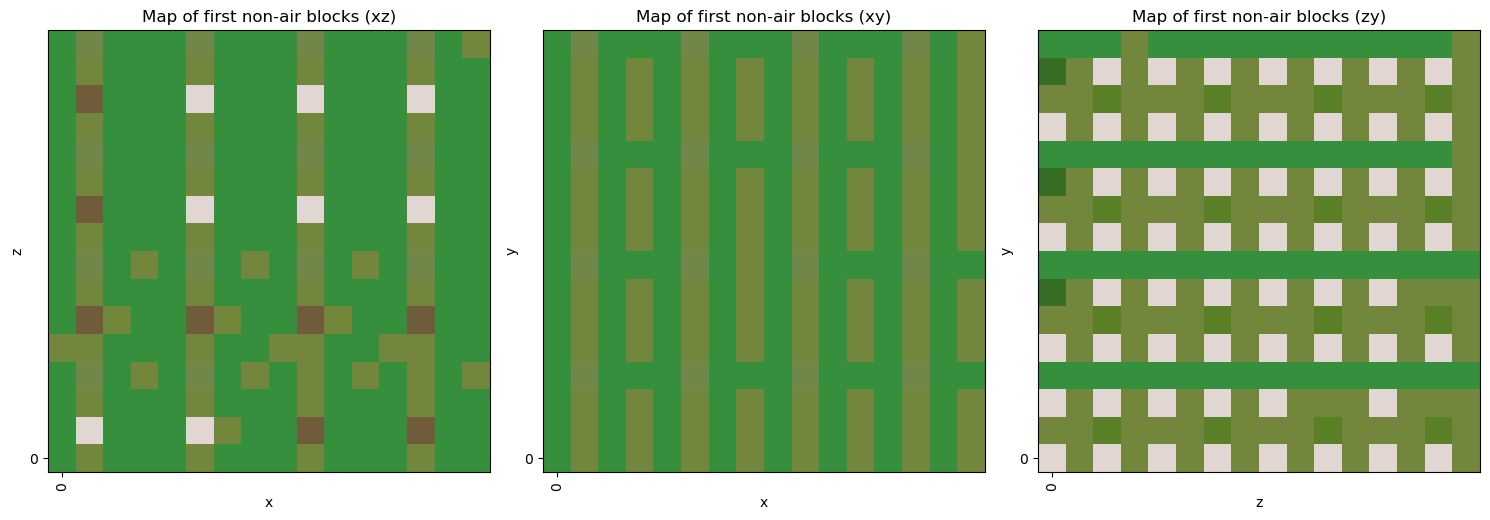

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


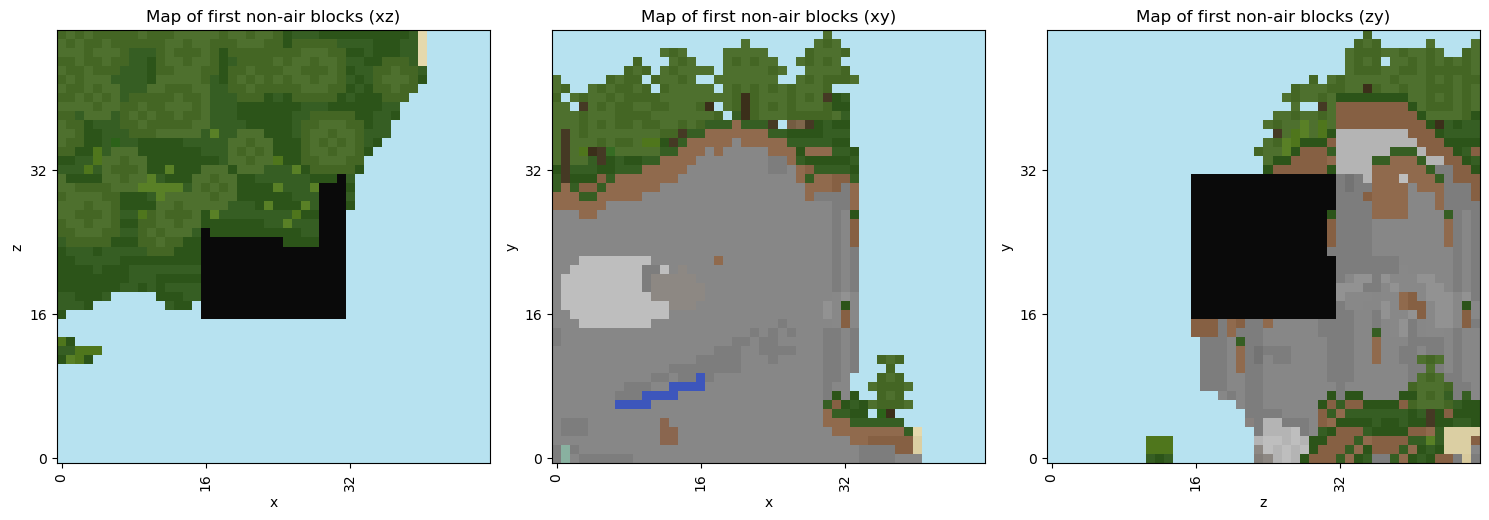

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


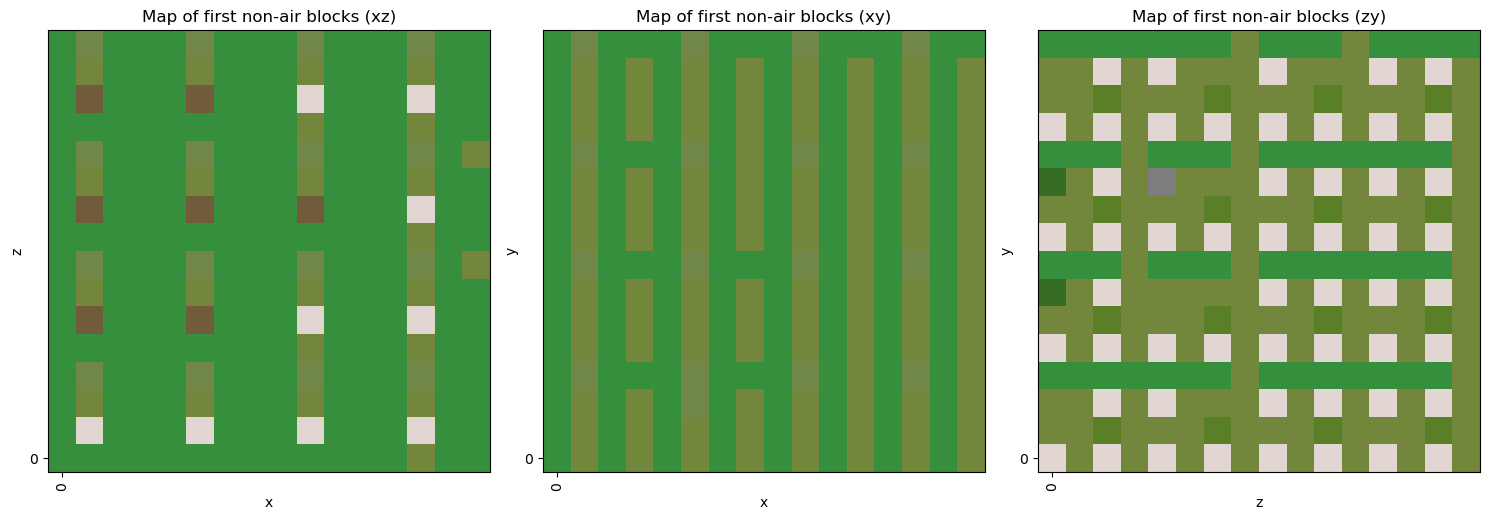

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


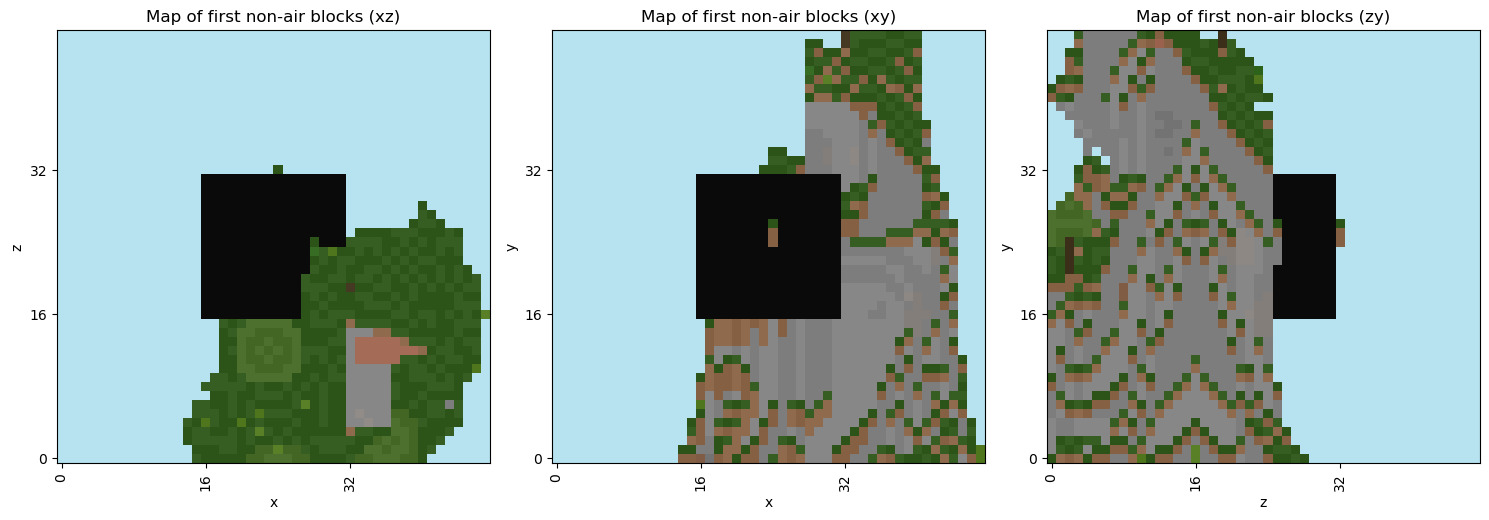

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


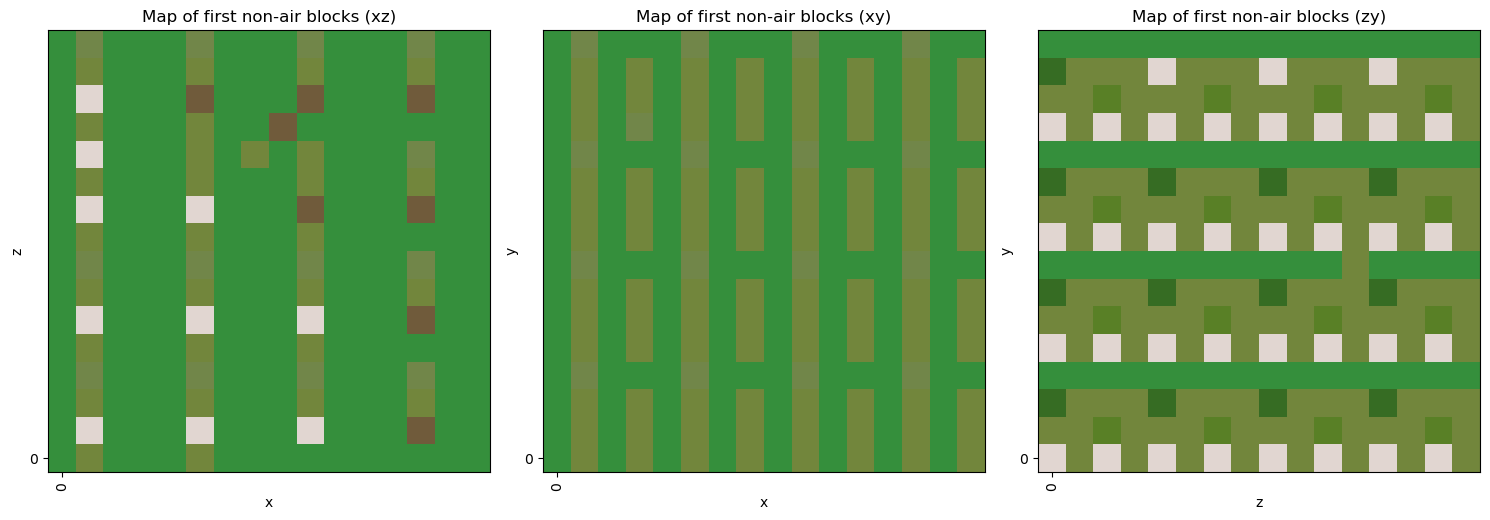

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


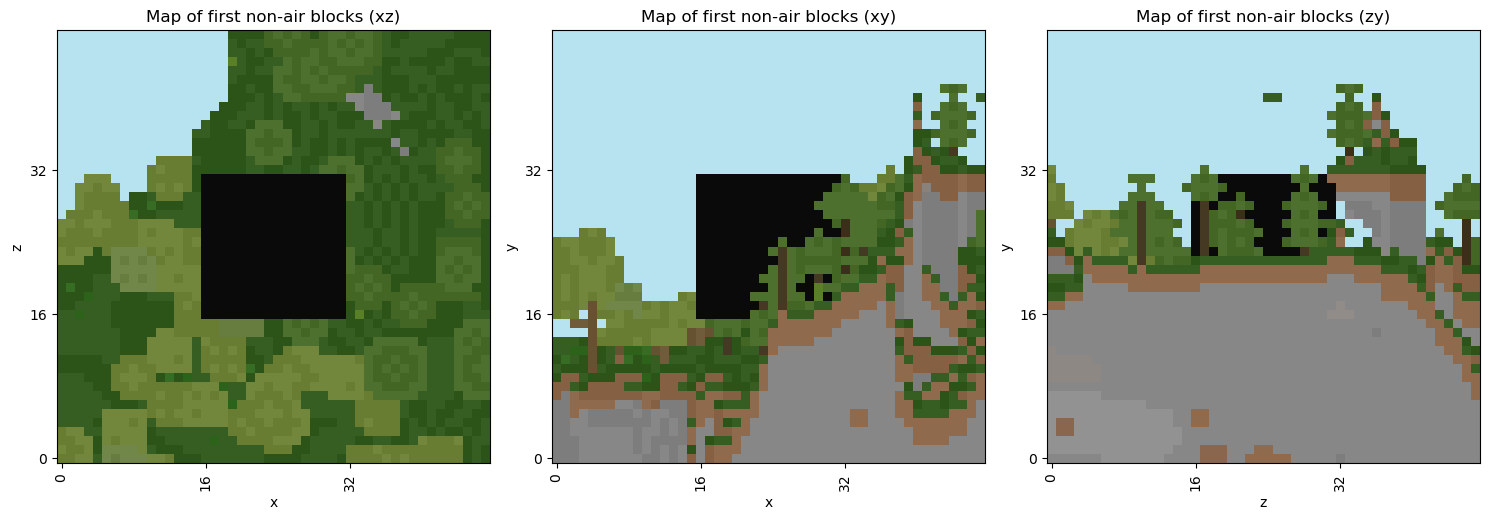

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


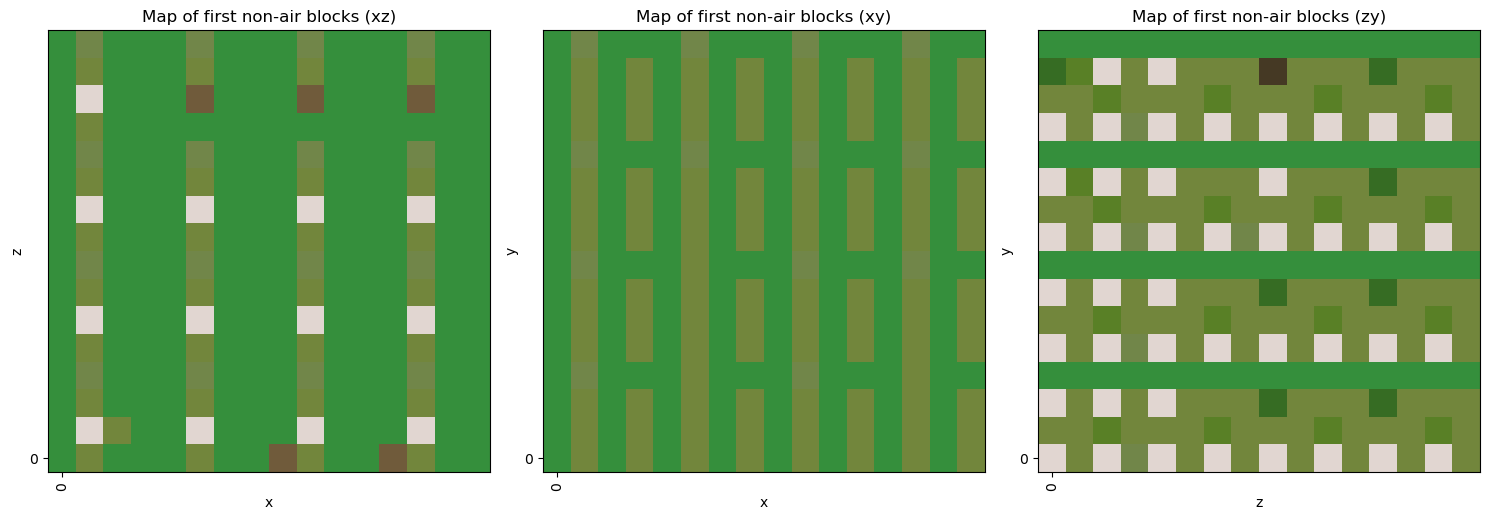

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


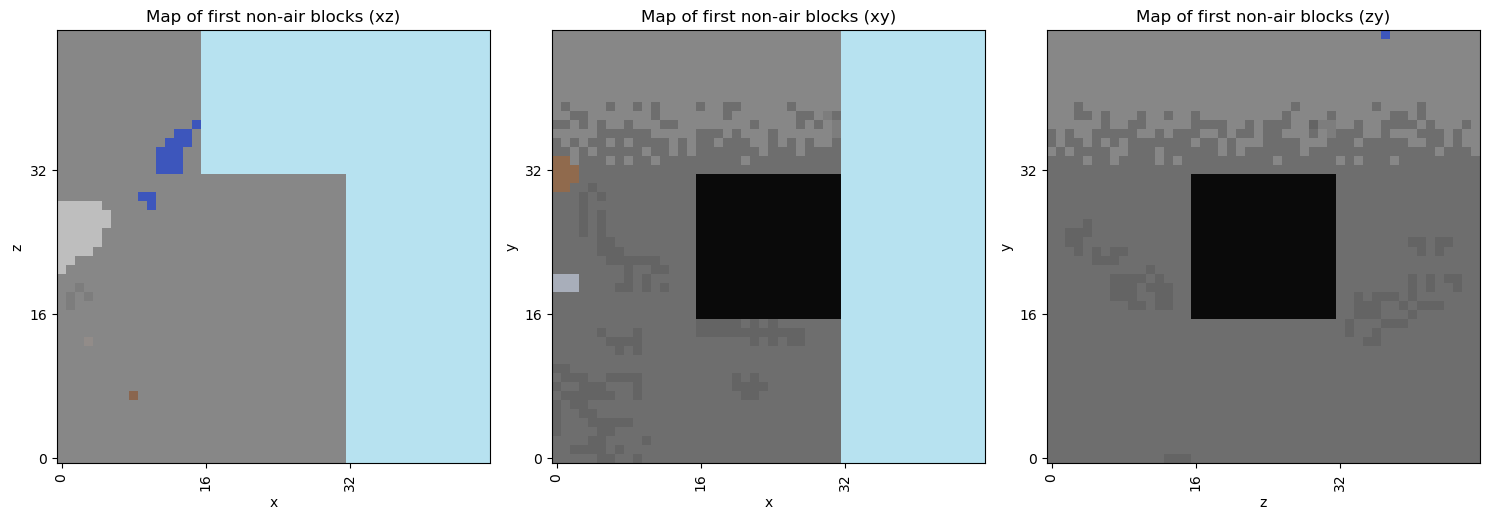

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


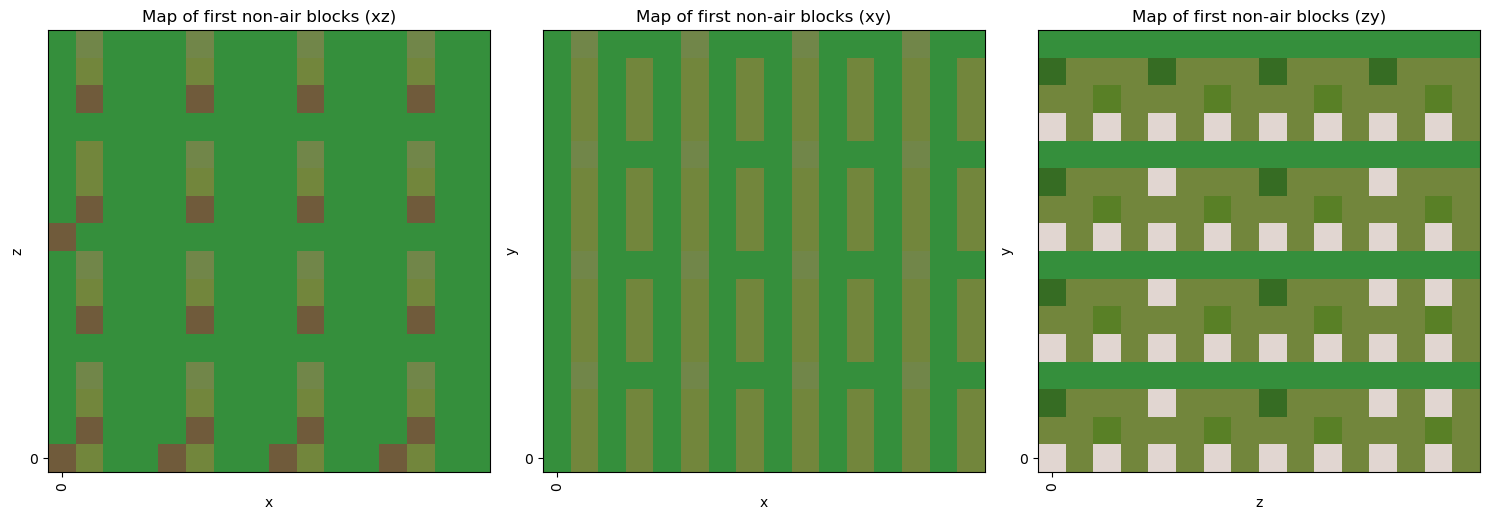

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


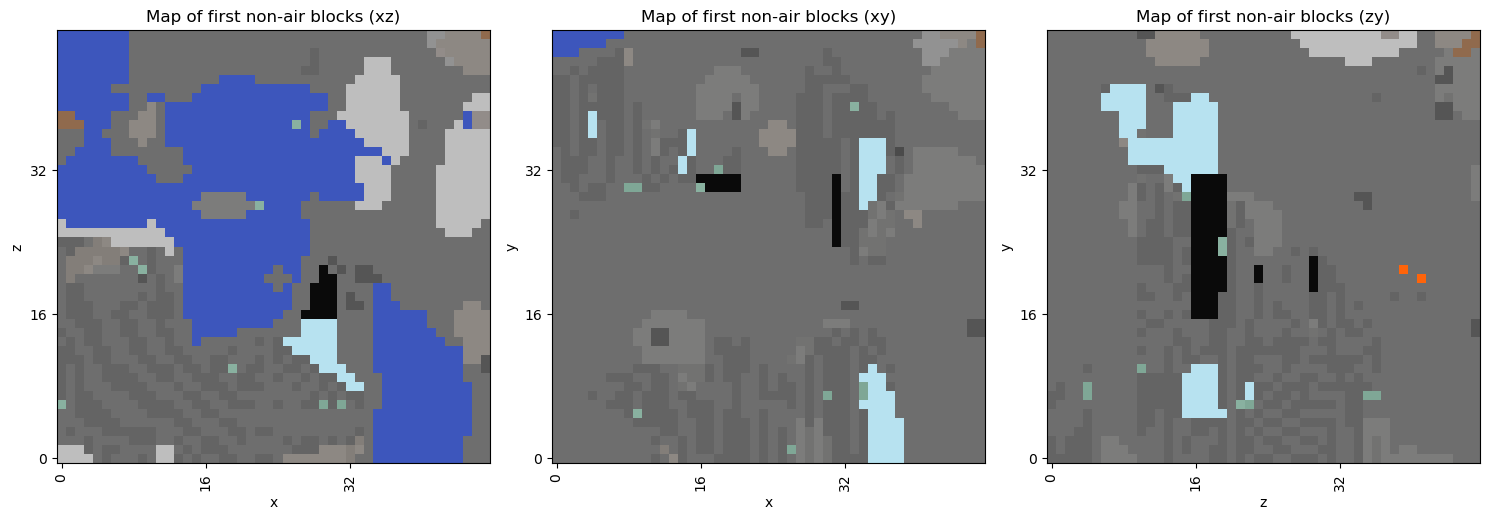

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


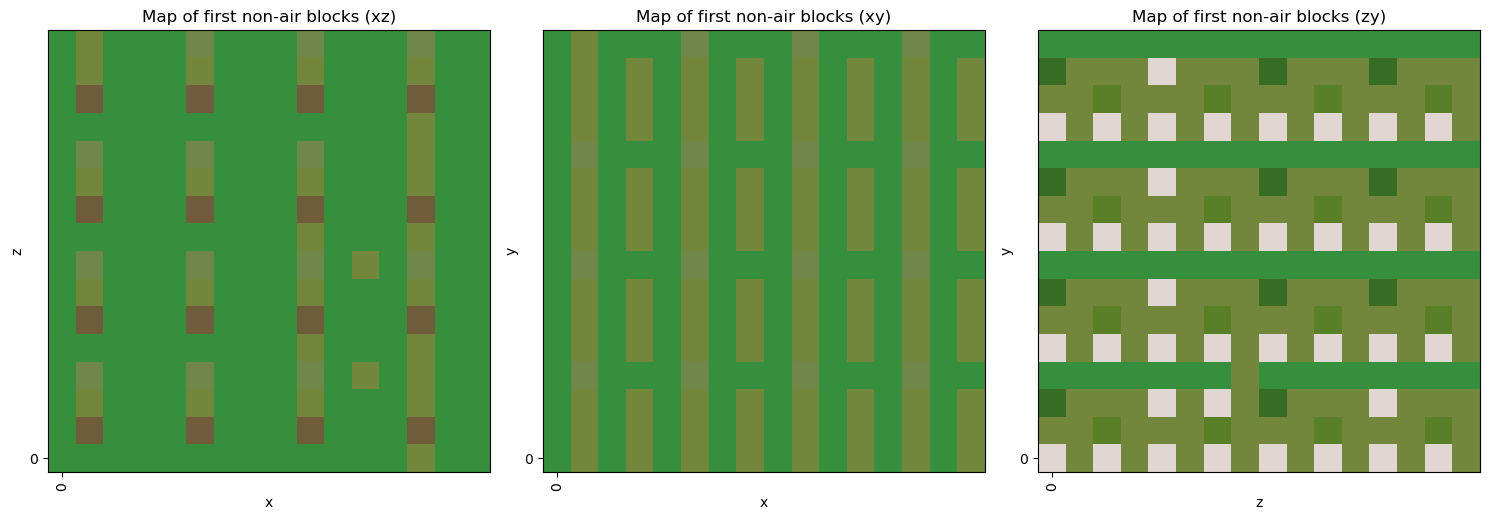

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


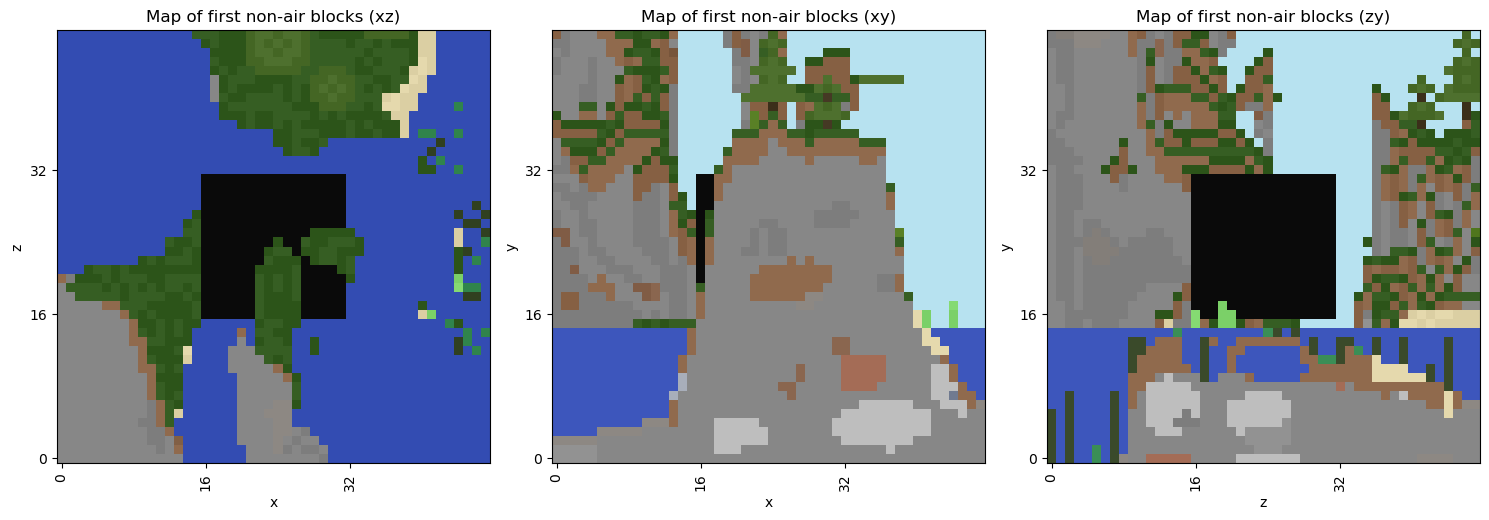

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


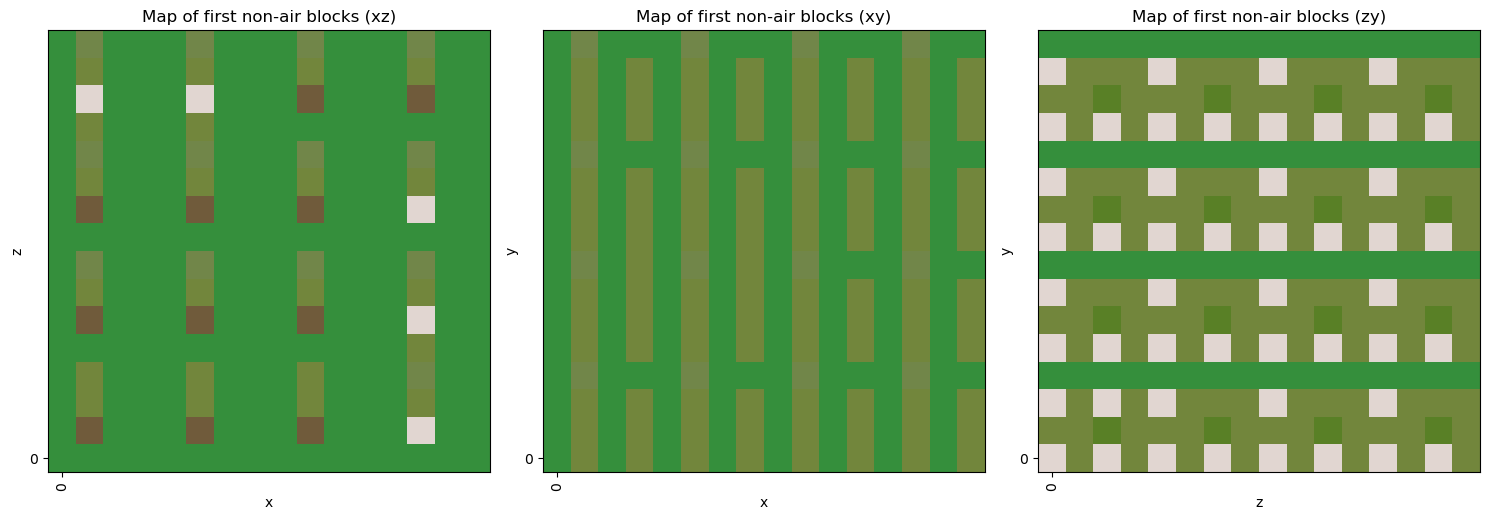

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


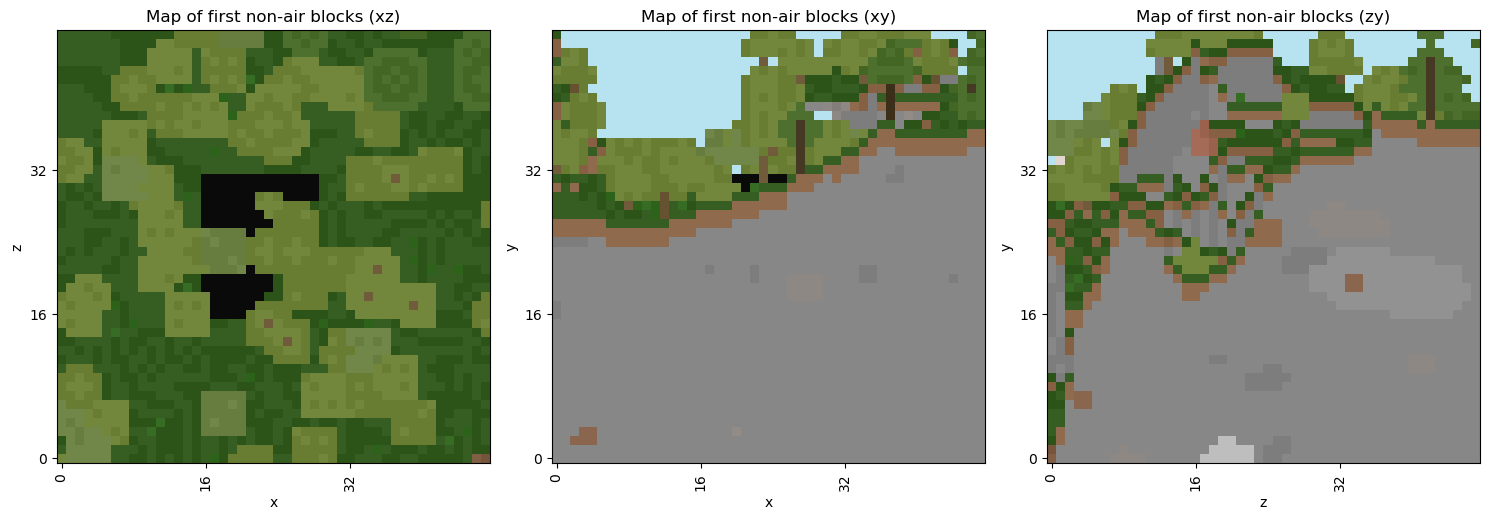

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


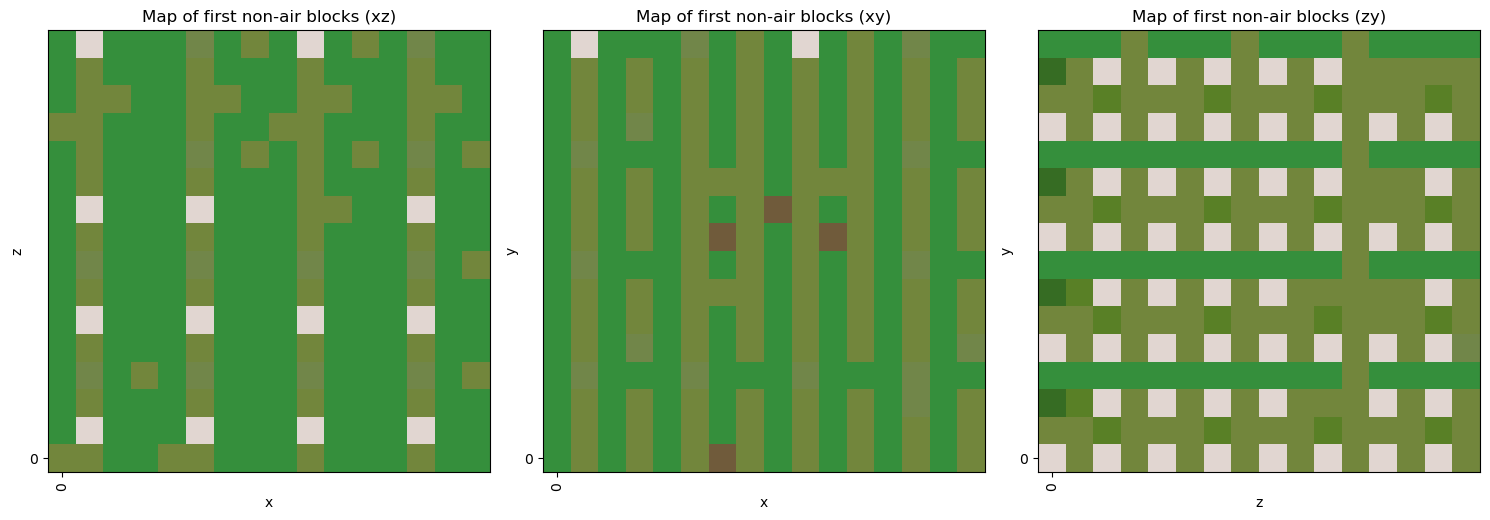

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


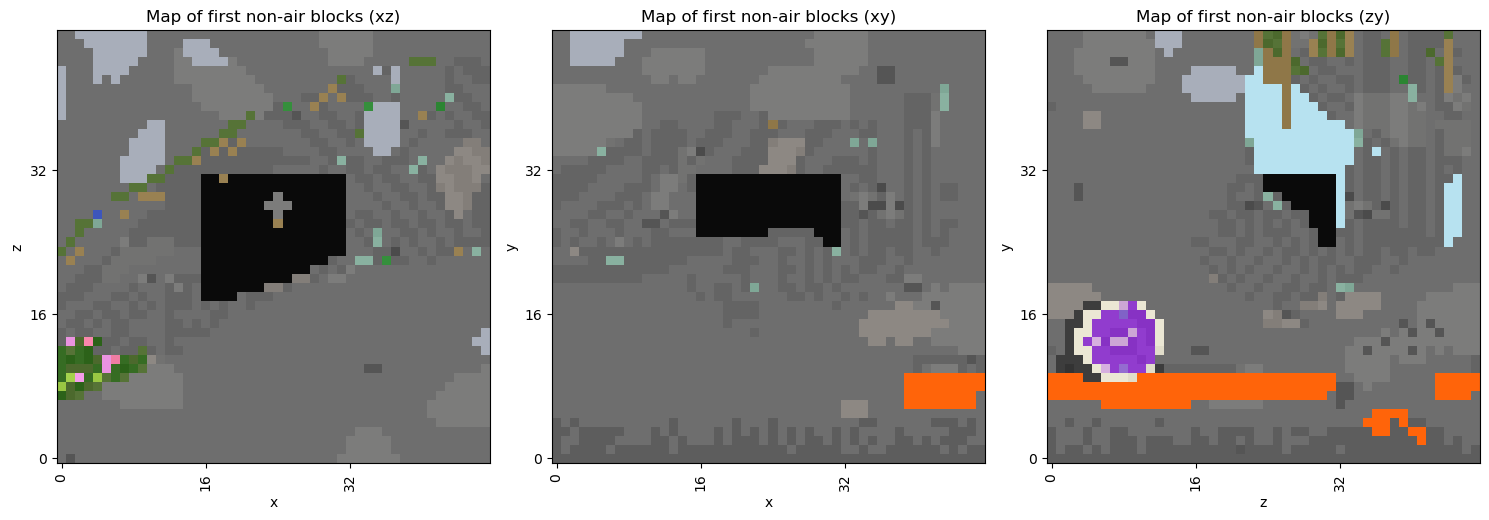

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


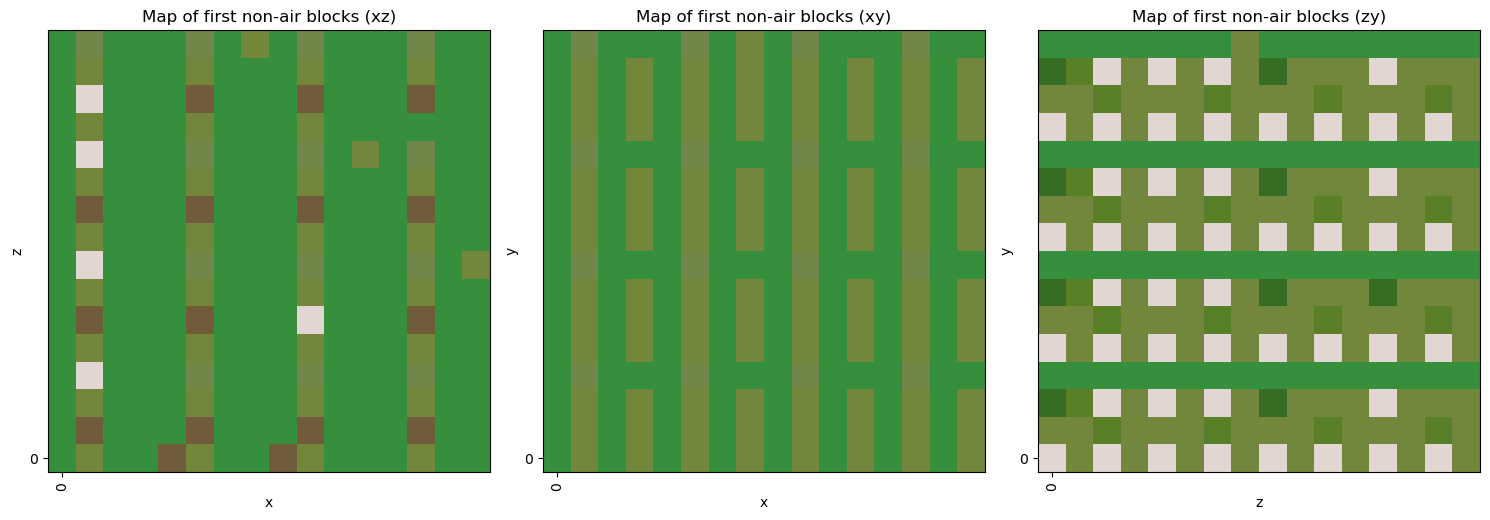

Masked Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


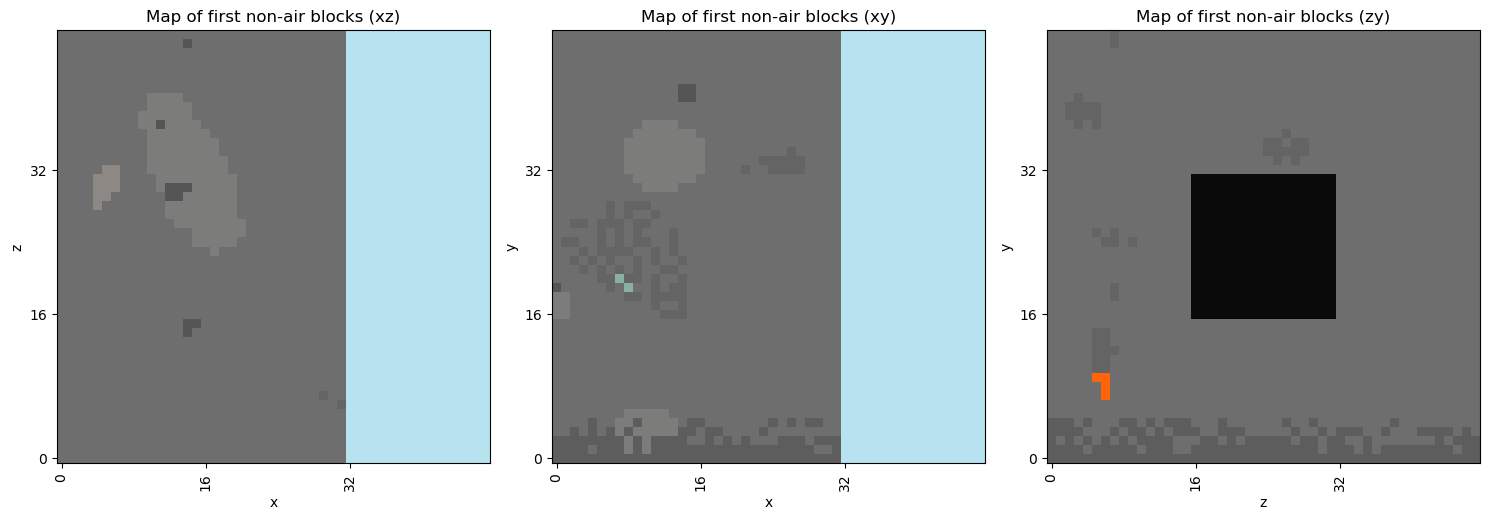

Predicted Center Section
✅ Loaded 1005 block states from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_id_dict.json.
✅ Loaded 1005 block colors from C:\Users\arnau\Desktop\blocksage\git\blocksage\data\block_color_dict.json.


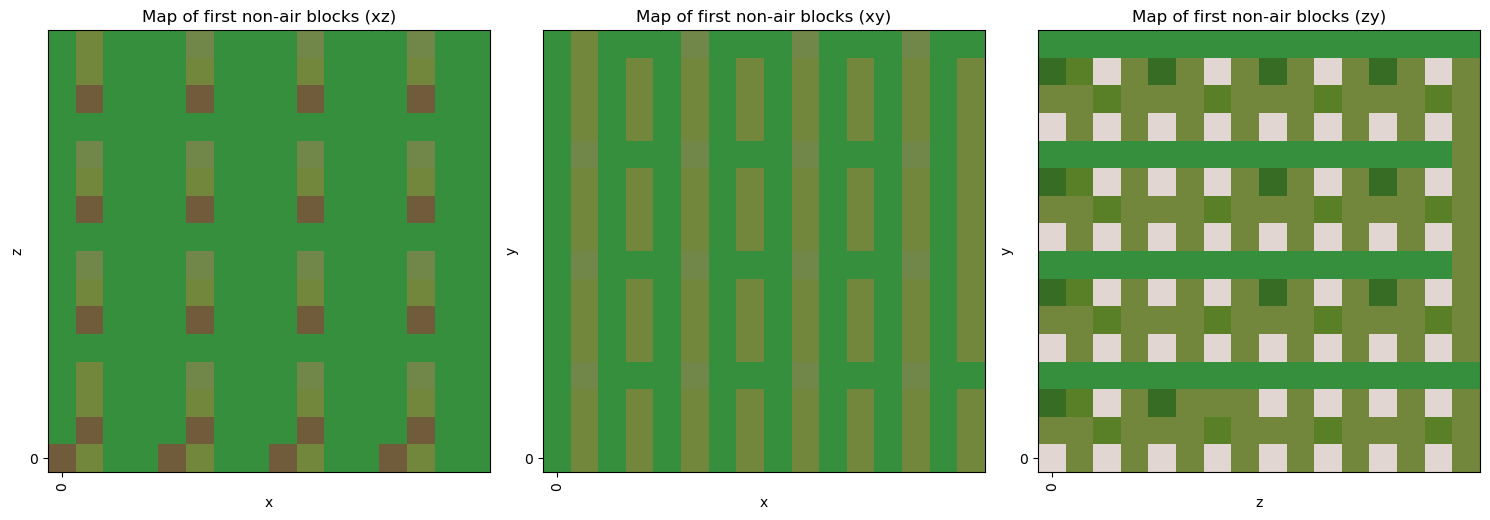

In [24]:
for i, batch in enumerate(cluster_dataloader):
    cluster_masked, cluster_gt = batch
    cluster_masked = cluster_masked.to(DEVICE)
    section_pred = model(cluster_masked)

    section_pred = section_pred.detach().cpu().numpy()
    cluster_masked = cluster_masked.detach().cpu().numpy()

    # one hot to idx
    cluster_masked = np.argmax(cluster_masked, axis=1)[0]
    section_pred = np.argmax(section_pred, axis=1)[0]

    # reshape back to original shape
    print("Masked Section")
    cluster_masked = cluster_masked.transpose((0, 2, 1)) \
        .reshape((3, 16, 3, 16, 3, 16)) \
        .transpose((0, 2, 4, 5, 3, 1))
    cluster_masked = Cluster(cluster_masked)
    cluster_masked.display()
    
    print("Predicted Center Section")
    cluster = Section(section_pred)
    cluster.display()

    if i == 10:
        break